In [1]:
# Importing the necessary packages
import numpy as np                                  # "Scientific computing"


import pandas as pd                                 # Data Frame

import matplotlib.pyplot as plt                     # Basic visualisation

from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the dataset
df = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets//clothes_size_prediction.csv')
df.head()

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M


## Take a look at the dataset

We'll try to predict the size based on the weight, age and height.   
  
Show some general info about the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119734 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119734 non-null  int64  
 1   age     119477 non-null  float64
 2   height  119404 non-null  float64
 3   size    119734 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


What are number of records for each size?  

M: 29575  
S: 21829  
XXXL: 21259  
XL: 19033  
L: 17481  
XXS: 9907  
XXL: 69

In [4]:
df['size'].value_counts()

M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
Name: size, dtype: int64

Because there are only very few records for XXL, remove those records from the dataset

In [5]:
df = df[df['size'] != 'XXL']

Train a transformer to fill in the median value of the corresponding attribute for all missing values.

In [6]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

df_num = df[['weight','height','age']]
imputer.fit(df_num)
imputer.statistics_

array([ 61. , 165.1,  32. ])

Apply the imputer to the dataset and check the results.

In [8]:
df_num_tr = imputer.transform(df_num)
df_num = pd.DataFrame(df_num_tr, columns=df_num.columns, index=df_num.index)
df = pd.concat([df_num, df[['size']]], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119665 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119665 non-null  float64
 1   height  119665 non-null  float64
 2   age     119665 non-null  float64
 3   size    119665 non-null  object 
dtypes: float64(3), object(1)
memory usage: 4.6+ MB


At first sight this seems quite a large dataset, but is this actually true?  
First we are going to change the datatype of height from float to integer.


In [9]:
df['height'] = df['height'].astype(int)

It seems reasonable to round the ages to the nearest five-fold

In [11]:
df['age'] = 5 * round(df['age'] / 5)

Change the datatype of age from float to integer.

In [12]:
df['age'] = df['age'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119665 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119665 non-null  float64
 1   height  119665 non-null  int32  
 2   age     119665 non-null  int32  
 3   size    119665 non-null  object 
dtypes: float64(1), int32(2), object(1)
memory usage: 3.7+ MB


We drop duplicate rows in the dataset.

In [13]:
df = df.drop_duplicates(keep='first')

How many records are left?

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11330 entries, 0 to 119721
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weight  11330 non-null  float64
 1   height  11330 non-null  int32  
 2   age     11330 non-null  int32  
 3   size    11330 non-null  object 
dtypes: float64(1), int32(2), object(1)
memory usage: 354.1+ KB


We want to know if there are any 'wrong duplicates' in the dataset, i.e. the same values for weight, age and height, but still another size. So we count the nunique

In [17]:
help = df.groupby(['weight','height','age']).nunique('size').reset_index()

We want to know how many records there are with the same values for weight, age and height, but another value for size.

In [18]:
help[help['size'] > 1]

,weight,height,age,size
1,22.0,167,30,2
14,40.0,149,30,2
18,40.0,154,30,2
20,40.0,157,30,2
26,40.0,165,25,2
...,...,...,...,...
4837,102.0,170,35,2
4972,108.0,170,30,2
4986,108.0,177,25,2
5004,111.0,162,55,2


We decide to remove those records and to keep the first one

In [19]:
df = df.drop_duplicates(subset=['weight','height','age'], keep='first')

How many records are left?

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5159 entries, 0 to 119682
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weight  5159 non-null   float64
 1   height  5159 non-null   int32  
 2   age     5159 non-null   int32  
 3   size    5159 non-null   object 
dtypes: float64(1), int32(2), object(1)
memory usage: 161.2+ KB


Check if the dataset is heavily skewed.

In [21]:
df['size'].value_counts()

XXXL    2326
M        689
XL       659
S        624
L        473
XXS      388
Name: size, dtype: int64

Because we want to apply regression first, map the sizes to numbers as follows:  
'XXS' : 0, 'S' : 1, 'M': 2, 'L': 3,'XL':4,'XXXL': 5

In [23]:
mapping_dict = {'XXS':0, 'S':1, 'M':2, 'L':3, 'XL':4,'XXXL': 5}
df['size'] = df['size'].map(mapping_dict)
df.head()

,weight,height,age,size
0,62.0,172,30,4
1,59.0,167,35,3
2,61.0,165,35,2
3,65.0,175,25,3
4,62.0,172,45,2


What is X and what is y?

In [24]:
X = df.drop(['size'], axis=1)
y = df['size']

What is X_train, y_train, X_test, y_test?

In [25]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

What is the shape of X_train, y_train, X_test and y_test?

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4127, 3), (1032, 3), (4127,), (1032,))

What are columns of X containing text?

In [27]:
X.select_dtypes(include=['object']).columns

Index([], dtype='object')

Define the ColumnTransformer for applying Standard Scaling on all numeric columns.  

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

col_transform = ColumnTransformer(transformers = [('std_scaler', StandardScaler(), X.columns)])


## Regression

Define the model LinearRegression  

In [31]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

Define the data preparation (= ColumnTransformer for standard scaling) and modeling pipeline

In [32]:
pipeline = Pipeline([('col_transform',col_transform),('lin_reg',lin_reg)])


Train the model

In [34]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('std_scaler',
                                                  StandardScaler(),
                                                  Index(['weight', 'height', 'age'], dtype='object'))])),
                ('lin_reg', LinearRegression())])

What is the accuracy of the model?  
Use K-fold cross-validation with k = 3.  
Find an appropriate value for the attribute scoring on [metrics and scoring](https://scikit-learn.org/stable/modules/model_evaluation.html) 

In [37]:
np.mean(-cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error'))

1.102898801164982

What are the values for intercept and the coefficients.  
Why are there 3 coefficients?  
Why do we have 3 coefficients?  
What is the most important coefficient?

In [38]:
lin_reg.intercept_, lin_reg.coef_

(3.433971407802278, array([1.33094381, 0.00512916, 0.2484815 ]))

Apply the model to the test set.  

In [40]:
y_test_predict = pipeline.predict(X_test)

Calculate the Mean Absolute Error and the Root Mean Squared Error

In [41]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

print('mae: ', mean_absolute_error(y_test,y_test_predict))
print('rmse: ', root_mean_squared_error(y_test,y_test_predict))

mae:  0.9203436604478166
rmse:  1.103009248760387


Interprete the results. 

## Classification

Use the softmax classifier to try to predict the class (0, 1, 2, 3, 4, 5).  
What is the accuracy score?

In [44]:
from sklearn.linear_model import LogisticRegression

softmax_reg = LogisticRegression(C=30, random_state=42)

pipeline = Pipeline([('col_transform',col_transform),('softmax',softmax_reg)])
pipeline.fit(X_train,y_train)

-np.mean(-cross_val_score(pipeline, X_train, y_train, cv=3, scoring='accuracy'))

0.6535031712473572

Create and show the confusion matrix for the test set.

In [45]:
from sklearn.metrics import confusion_matrix
y_test_predict = pipeline.predict(X_test)
confusion_matrix(y_test, y_test_predict)

array([[ 37,  30,   4,   0,   0,   0],
       [ 21,  81,  33,   0,   2,   5],
       [  0,  22, 101,   0,  10,   5],
       [  1,   4,  44,   0,  30,  13],
       [  0,   3,  27,   0,  43,  51],
       [  1,   1,   7,   0,  23, 433]], dtype=int64)

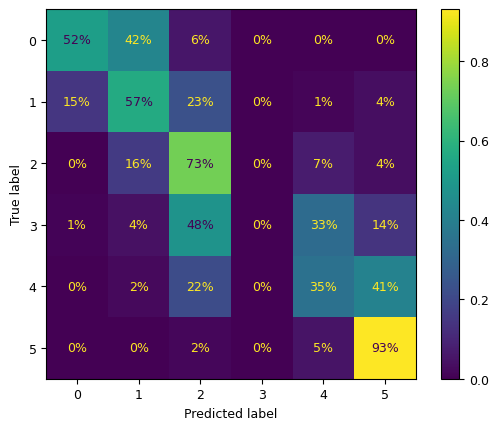

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=9)  # extra code – make the text smaller
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict,normalize="true", values_format=".0%")
plt.show()

The accuracy of the classifier is low, but we see that we often predict only one size too high or too small. 
Calculate how many times 
* the classifier was correct
* the classifier predicted the size to be one size higher than the actual size
* the classifier predicted the size to be one size smaller than the actual size


correct = 860
oneSizeTooHigh = 185
oneSizeTooSmall = 138
Total number of predictions = 1290
